<a href="https://www.kaggle.com/code/masatomurakawamm/n-beats-dnn-for-univariate-time-series-forecast?scriptVersionId=105416699" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
# [Tabular Playground Series - Sep 2022][1]

The competing Kaggle merchandise stores we saw in [January's Tabular Playground](https://www.kaggle.com/c/tabular-playground-series-jan-2022) are at it again. The task for this month's competitions is a bit more complicated. Not only are there six countries and four books to forecast, but you're being asked to forecast sales during the tumultuous year 2021.

---
## **About This Notebook:**
### **[Aim]** The aim of this notebook is to implement N-BEATS model from scratch with PyTorch and build an experimentation platform for hyperparameter tuning. You can easily try experiments with new hyperparameters by changing the settings in the first cell of <a href="#1">Chapter1</a> and running all the cells (both CPU and GPU).

### **[Results]** The evaluation score of N-BEATS is not as good as top-scored solutions in shared notebooks. This may be because N-BEATS is an univariate model. Making full use of all features' information would be a key to improving the quality of prediction.

---
N-BEATS, the Neural Basis Expansion Analysis for Time Series, was first described in 2019. This is a univariate deep neural network model and has the structure below:

<img src="https://miro.medium.com/max/4800/1*J0VrOHLkNZydI1yk6a3r_A.png" width="700"/>

- For the details of the N-BEATS model, please check <a href="#4.2">Chapter4.2 N-BEATS</a>, or please refer to [the original paper](https://arxiv.org/abs/1905.10437).
- You can also use N-BEATS implementations by [Darts](https://unit8co.github.io/darts/examples/07-NBEATS-examples.html), [GluonTS](https://ts.gluon.ai/stable/), [PyTorch Forecasting](https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.nbeats.NBeats.html), or other time series forecasting libraries.

---
**References:** Thanks to previous great codes, blogs and notebooks.

- I refered to [TPS Sep22: EDA & Baseline You Were Looking For 🎈][2] for EDA.

---
### **If you find this notebook useful, or when you copy&edit this notebook, please do give me an upvote. It helps me keep up my motivation.**

---
[1]: https://www.kaggle.com/competitions/tabular-playground-series-sep-2022
[2]: https://www.kaggle.com/code/jcaliz/tps-sep22-eda-baseline-you-were-looking-for

<span id='toc'/>

<h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>0. TABLE OF CONTENTS</center></h1>

<ul class="list-group" style="list-style-type:none;">
    <li><a href="#1" class="list-group-item list-group-item-action">1. Settings</a></li>
    <li><a href="#2" class="list-group-item list-group-item-action">2. Data Loading</a></li>
    <li><a href="#3" class="list-group-item list-group-item-action">3. EDA and Feature Engineering</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#3.1" class="list-group-item list-group-item-action">3.1 Data Check</a></li>
            <li><a href="#3.2" class="list-group-item list-group-item-action">3.2 Exploratory Data Analysis</a></li>
            <li><a href="#3.3" class="list-group-item list-group-item-action">3.3 Feature Engineering</a></li>
            <li><a href="#3.4" class="list-group-item list-group-item-action">3.4 Dataset</a></li>
        </ul>
    </li>
    <li><a href="#4" class="list-group-item list-group-item-action">4. Model</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#4.1" class="list-group-item list-group-item-action">4.1 Preprocessing Model</a></li>
            <li><a href="#4.2" class="list-group-item list-group-item-action">4.2 N-BEATS</a></li>
        </ul>
    </li>
    <li><a href="#5" class="list-group-item list-group-item-action">5. Training</a></li>
    <li><a href="#6" class="list-group-item list-group-item-action">6. Prediction</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#6.1" class="list-group-item list-group-item-action">6.1 Test Dataset</a></li>
            <li><a href="#6.2" class="list-group-item list-group-item-action">6.2 Test Data Prediction</a></li>
        </ul>
    </li>
</ul>

<a id ="1"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>1. Settings</center></h1>
[Back to the TOC](#toc)

In [1]:
## Parameters
data_config = {
    'train.csv': '../input/tabular-playground-series-sep-2022/train.csv',
    'test.csv': '../input/tabular-playground-series-sep-2022/test.csv',
    'sample_submission.csv': '../input/tabular-playground-series-sep-2022/sample_submission.csv',
}

exp_config = {
    'competition_name': 'tps-sep-2022',
    'history_period': 60,  ## Lookback period (days)
    'horizon_period': 30,  ## Forecast period (days)
    'val_ratio': 0.25,  ## Train-vaild split ratio
    'batch_size': 512,
    'train_epochs': 6,
    'learning_rate': 1e-3,
    'gamma': 0.99,  ## parameter of learning scheduler
    'train_limit': True,  ## Use or not the data before 2020
    'finalize': True,  ## For the model finalization
}

model_config = {
    'emb_dim': 6,  ## categorical features' representation dim
    'n_blocks': 2,  ## number of N-BEATS blocks in a stack
    'n_stacks': 4,  ## number of N-BEATS stacks
    'width': 32,  ## hidden dim in N-BEATS
}

print('Parameters setted!')

Parameters setted!


In [2]:
## Import dependencies 
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os, sys, pathlib, gc
import re, math, random, time
import datetime as dt
from tqdm import tqdm
from typing import Optional, Union, Tuple
from collections import OrderedDict

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

print('import done!')

import done!


In [3]:
## For reproducible results    
def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed(s)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(s) 
    print('Seeds setted!')
global_seed = 42
seed_all(global_seed)


## Limit GPU Memory in TensorFlow
## Because TensorFlow, by default, allocates the full amount of available GPU memory when it is launched. 
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
    
    
## For Seaborn Setting
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha': 0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'figure.facecolor': '#fdfcf6',
    'axes.facecolor': '#fdfcf6',
}
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
sns.set_theme(
    style='whitegrid',
    #palette=sns.color_palette(cluster_colors),
    rc=custom_params,
)

Seeds setted!
Not enough GPU hardware devices available


<a id ="2"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>2. Data Loading</center></h1>
[Back to the TOC](#toc)

---
### [File and Data Field Descriptions](https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/data)
For this challenge, you will be predicting a full year worth of sales for 4 items from two competing stores located in six different countries. This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc.

- **train.csv** - the training set, which includes the sales data for each date-country-store-item combination.

- **test.csv** - the test set; your task is to predict the corresponding item sales for each date-country-store-item combination. Note the Public leaderboard is scored on the first quarter of the test year, and the Private on the remaining.

- **sample_submission.csv** - a sample submission file in the correct format

---
### [Submission & Evaluation](https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/overview/evaluation)

- Submissions are evaluated on [Symmetric mean absolute percentage error (SMAPE)](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) between forecasts and actual values. We define SMAPE = 0 when the actual and predicted values are both 0.

---

In [4]:
## Data Loading
train_df = pd.read_csv(data_config['train.csv'])
test_df = pd.read_csv(data_config['test.csv'])
submission_df = pd.read_csv(data_config['sample_submission.csv'])

print(f'train_length: {len(train_df)}')
print(f'test_lenght: {len(test_df)}')
print(f'submission_length: {len(submission_df)}')

train_length: 70128
test_lenght: 17520
submission_length: 17520


<a id ="3"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>3. EDA and Feature Engineering</center></h1>

<a id ="3.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.1 Data Check</center></h2>
[Back to the TOC](#toc)

In [5]:
## Null Value Check
print('train_df.info()'); print(train_df.info(), '\n')
print('test_df.info()'); print(test_df.info(), '\n')

## train_df Check
train_df.head()

train_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB
None 

test_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   17520 non-null  int64 
 1   date     17520 non-null  object
 2   country  17520 non-null  object
 3   store    17520 non-null  object
 4   product  17520 non-null  object
dtypes: int64(1), object(4)
memory usage: 684.5+ KB
None 



,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


---
There are no missing values.

---

In [6]:
## Features and Targets
original_features = ['date', 'country', 'store', 'product']
target = 'num_sold'

## Number of unique values in each features.
n_unique_features = {feature: train_df[feature].nunique() for feature in original_features}
n_unique_features

{'date': 1461, 'country': 6, 'store': 2, 'product': 4}

In [7]:
## test_df Check
test_df.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


<a id ="3.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.2 Exploratory Data Analysis</center></h2>
[Back to the TOC](#toc)

In [8]:
## Statistics of num_sold
train_df['num_sold'].describe()

count    70128.000000
mean       194.296986
std        126.893874
min         19.000000
25%         95.000000
50%        148.000000
75%        283.000000
max        986.000000
Name: num_sold, dtype: float64

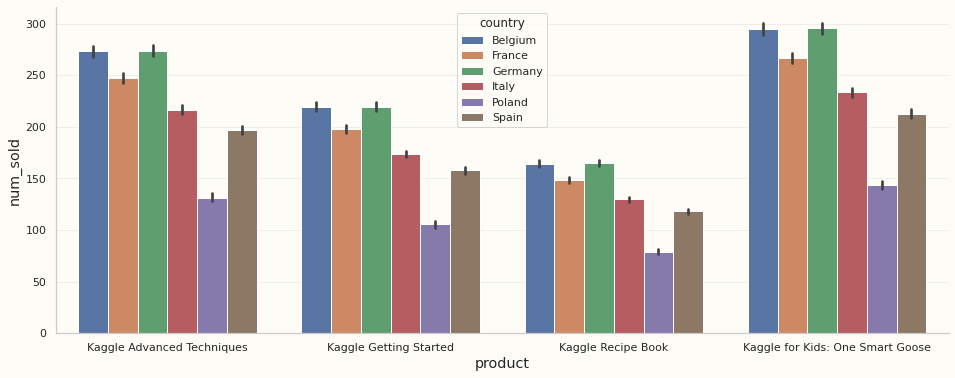

In [9]:
## num_sold of each product in each country
ax = sns.barplot(data=train_df, x='product', y='num_sold', hue='country')

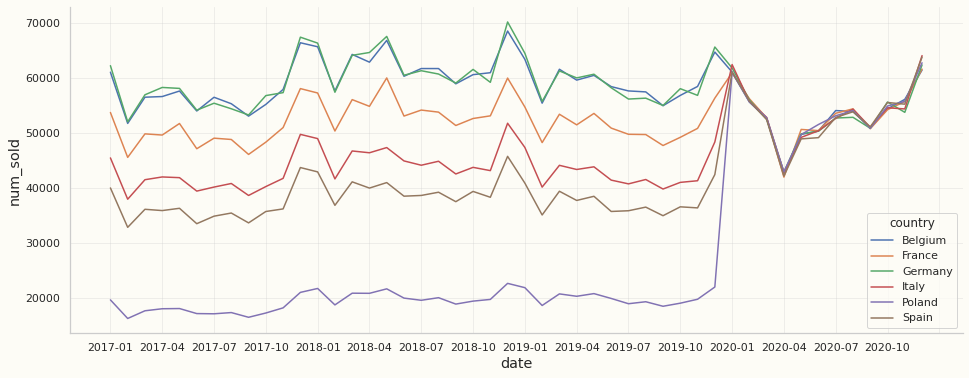

In [10]:
## Total sells by Country
train_df['date'] = pd.to_datetime(train_df['date'])

ax = sns.lineplot(
    data=train_df.groupby([
        train_df.date.dt.strftime('%Y-%m'),
        train_df.country
    ])['num_sold'].sum().reset_index(),
    x='date',
    y='num_sold',
    hue='country',
)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))

---
The tendency has been changed in 2020.

---

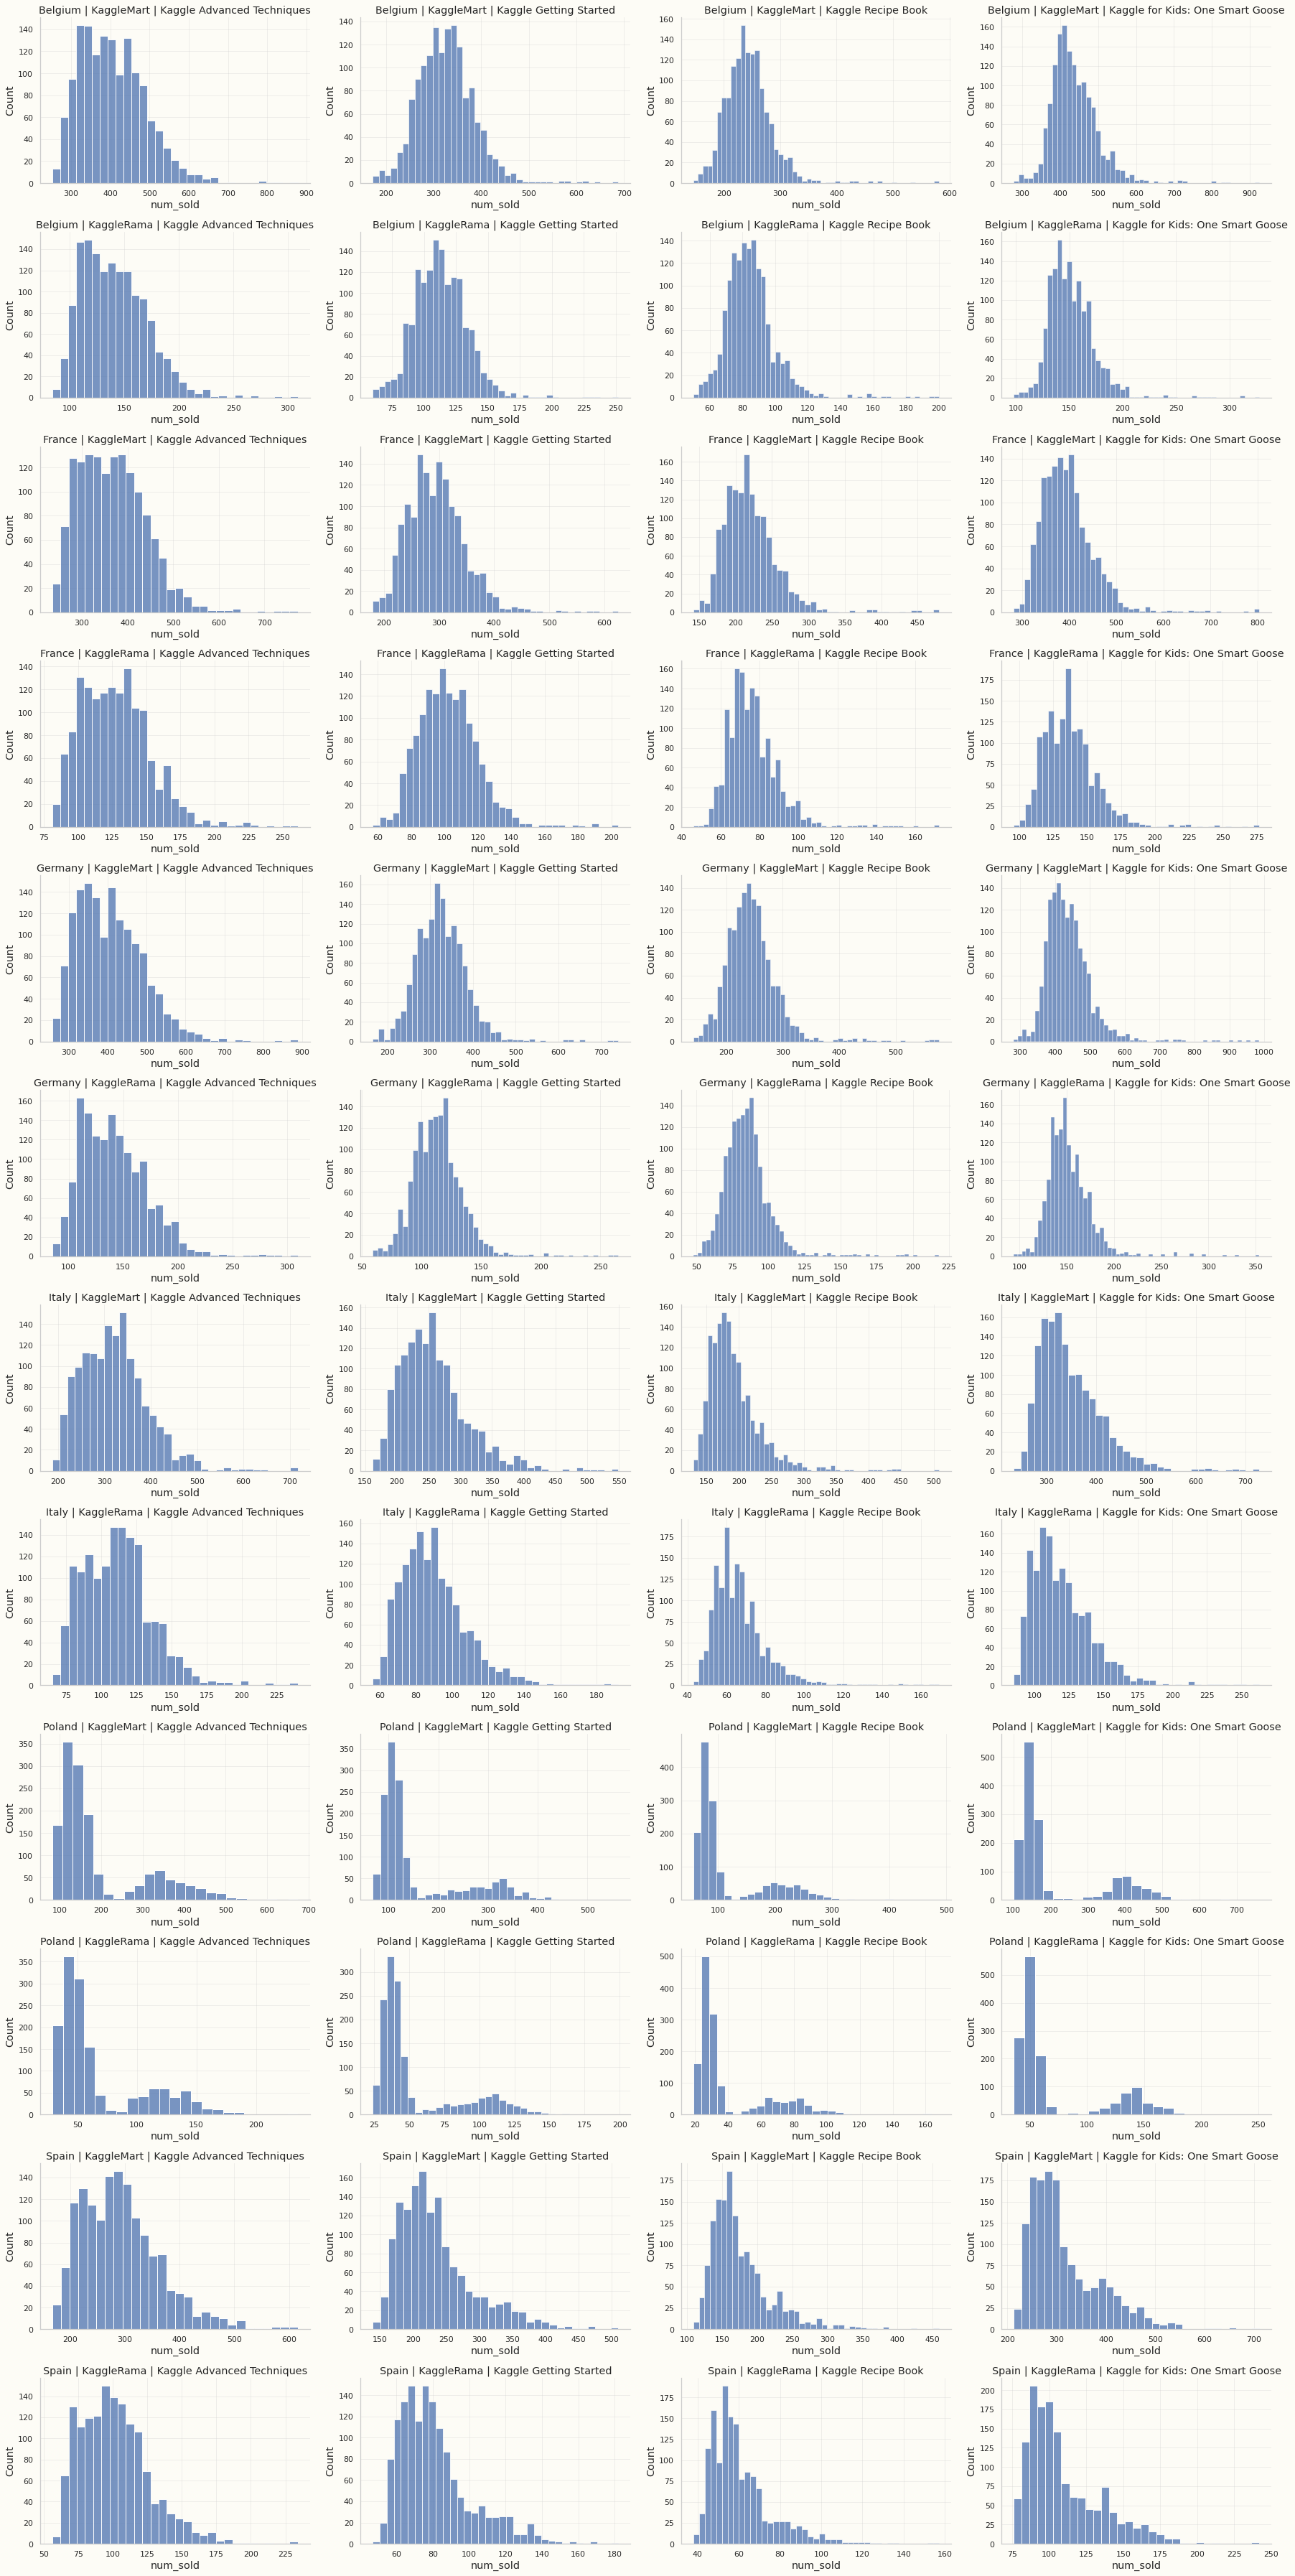

In [11]:
## Distrubutions of num_sold
fig, ax = plt.subplots(12, 4, figsize=(25, 50))
ax = ax.flatten()

for i, (combination, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    sns.histplot(df.num_sold, ax=ax[i])
    ax[i].set_title(' | '.join(combination))
plt.tight_layout()

---
The distributions are differentiated by country, store, and product. These features can be useful for ML model training. However, N-BEATS model is for univariate times series forecasting problem. Thus, I use only "num_sold" for training of N-BEATS model later in this notebook.

---

<a id ="3.3"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.3 Feature Engineering</center></h2>
[Back to the TOC](#toc)

In [12]:
## Datetime Feature Engineering
def date_feature_eng(df, date_column_name, drop=True):
    df[date_column_name] = pd.to_datetime(df[date_column_name])
    df['year'] = df[date_column_name].dt.year
    df['month'] = df[date_column_name].dt.month
    df['day'] = df[date_column_name].dt.day
    df['dayofweek'] = df[date_column_name].dt.dayofweek
    
    if drop:
        df = df.drop(date_column_name, axis=1)
        
    return df

## Create date-related features
train_df = date_feature_eng(train_df, 'date')
test_df = date_feature_eng(test_df, 'date')

## Use or not the data before 2020
if exp_config['train_limit']:
    train_df = train_df[train_df['year']==2020]
    train_df = train_df.reset_index(drop=True)

In [13]:
## Standardization of numerical featurs and target

## Only 'num_sold' is numerical in this data set
train_num_sold = train_df['num_sold'].values
train_num_sold = train_num_sold.reshape(-1, 1)

## Using sklearn.preprocessing.StandardScaler
sc = StandardScaler()
sc.fit(train_num_sold)
print('StandardScaler mean: ', sc.mean_)
print('StandardScaler scale: ', sc.scale_)

## Check
train_df['num_sold'] = sc.transform(train_num_sold)
train_df['num_sold'].describe()

StandardScaler mean:  [219.44404599]
StandardScaler scale:  [127.00154427]


count    1.756800e+04
mean     1.617811e-17
std      1.000028e+00
min     -1.373558e+00
25%     -8.381319e-01
50%     -3.656967e-01
75%      8.409815e-01
max      4.279916e+00
Name: num_sold, dtype: float64

In [14]:
## Making Lookup table of categorical featurs and target
numerical_columns = ['num_sold']
categorical_columns = ['country', 'store', 'product', 'month', 'day', 'dayofweek']
## I will not use 'year' as a categorical feature.
## Because there are no overlapping in 'year' feature between train and test data.
## It means that the model can't learn the embedding of year==2021.

## Using sklearn.preprocessing.OrdinalEncoder
oe = OrdinalEncoder(handle_unknown='error',
                    dtype=np.int64)
encoded = oe.fit_transform(train_df[categorical_columns].values)
#decoded = oe.inverse_transform(encoded)
train_df[categorical_columns] = encoded
test_df[categorical_columns] = oe.transform(test_df[categorical_columns].values)

## Check
encoder_categories = oe.categories_
encoder_categories

[array(['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain'],
       dtype=object),
 array(['KaggleMart', 'KaggleRama'], dtype=object),
 array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
        'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
       dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6], dtype=object)]

---
Please note that I don't use these categorical features for the training of N-BEATS model, because N-BEATS is for univariate.

---

<a id ="3.4"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>3.4 Dataset</center></h2>
[Back to the TOC](#toc)

I will make a dataset that provides the time series input data and labels for the model training. The strategies are follows: When the dataset receives the index, it returns the past lookback history of "num_sold" in the same country, at the same store, of the same product.

In [15]:
train_data = train_df.copy()

## Settings
n_country = 6
n_store = 2
n_product = 4
n_items = n_country * n_store * n_product ## 48
n_days = int(len(train_data) / n_items) ## 1461

history_period = exp_config['history_period']  ## Lookback period
horizon_period = exp_config['horizon_period']  ## Forecast period
before_start_idx = n_items * history_period
after_end_idx = n_items * horizon_period

## Helper Functions
def collect_past_data(idx, period, n_items) -> list:
    if idx < n_items * period:
        return []
    past_start_idx = idx - n_items * period
    past_data_ids = [i * n_items + past_start_idx for i in range(period)]
    return past_data_ids

def collect_future_data(idx, period, n_items) -> list:
    future_data_ids = [i * n_items + idx for i in range(period)]
    return future_data_ids

## Operation Check
a = 10000
b = collect_past_data(a, history_period, n_items)
c = collect_future_data(a, horizon_period, n_items)
print('index example: ', a, '\n')
print('history index: \n', b, '\n')
print('prediction index: \n', c, '\n')

index example:  10000 

history index: 
 [7120, 7168, 7216, 7264, 7312, 7360, 7408, 7456, 7504, 7552, 7600, 7648, 7696, 7744, 7792, 7840, 7888, 7936, 7984, 8032, 8080, 8128, 8176, 8224, 8272, 8320, 8368, 8416, 8464, 8512, 8560, 8608, 8656, 8704, 8752, 8800, 8848, 8896, 8944, 8992, 9040, 9088, 9136, 9184, 9232, 9280, 9328, 9376, 9424, 9472, 9520, 9568, 9616, 9664, 9712, 9760, 9808, 9856, 9904, 9952] 

prediction index: 
 [10000, 10048, 10096, 10144, 10192, 10240, 10288, 10336, 10384, 10432, 10480, 10528, 10576, 10624, 10672, 10720, 10768, 10816, 10864, 10912, 10960, 11008, 11056, 11104, 11152, 11200, 11248, 11296, 11344, 11392] 



In [16]:
## Dataset
class TPSSep22TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, numerical_columns, 
                 categorical_columns,
                 history_period=30,
                 horizon_period=30,
                 n_items=48,
                 target=None):
        self.df = df
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.history_period = history_period
        self.horizon_period = horizon_period
        self.n_items = n_items
        self.target = target
        self.before_start_idx = n_items * history_period
        self.after_end_idx = n_items * horizon_period
        
    def __len__(self):
        return (len(self.df) - self.before_start_idx - self.after_end_idx)
    
    def __getitem__(self, index):
        data = OrderedDict()
        index = index + self.before_start_idx
        
        data['row_id'] = self.df['row_id'][index]
        
        for nc in self.numerical_columns:
            past_data_ids = collect_past_data(index,
                                              self.history_period,
                                              self.n_items)
            x = torch.tensor(self.df[nc][past_data_ids].values,
                             dtype=torch.float32)
            name = 'past_' + nc
            data[name] = x
        
        for cc in self.categorical_columns:
            x = torch.tensor(self.df[cc][index],
                             dtype=torch.int32)
            x = torch.unsqueeze(x, dim=0)
            data[cc] = x
        
        if self.target is not None:
            if index + self.after_end_idx < len(self.df):
                future_data_ids = collect_future_data(index,
                                                      self.horizon_period,
                                                      self.n_items)
                label = torch.tensor(self.df[self.target][future_data_ids].values,
                                     dtype=torch.float32)
            else:
                label = torch.tensor(self.df[self.target][index],
                                     dtype=torch.float32)
            return data, label
        else:
            return data

In [17]:
## train-valid split
if exp_config['train_limit']:
    val_ratio = 0.3
else:
    val_ratio = exp_config['val_ratio']

n_val = int((len(train_data) - before_start_idx - after_end_idx) / n_items * val_ratio) * n_items
n_train = len(train_data) - before_start_idx - after_end_idx - n_val
print(n_train, n_val)

train = train_data[:n_train + before_start_idx].reset_index(drop=True)
valid = train_data[-(n_val + after_end_idx):].reset_index(drop=True)
print(len(train), len(valid))

9312 3936
12192 5376


In [18]:
## Making Dataset
train_ds = TPSSep22TrainDataset(train, 
                                numerical_columns,
                                categorical_columns,
                                history_period,
                                horizon_period,
                                n_items,
                                target)

val_ds = TPSSep22TrainDataset(valid,
                              numerical_columns,
                              categorical_columns,
                              history_period,
                              horizon_period,
                              n_items,
                              target)

## Operation Check
print('length of train_ds: ', len(train_ds))
print('length of val_ds: ', len(val_ds))
index = 0
sample = train_ds.__getitem__(index)
print('\n', sample)

length of train_ds:  7872
length of val_ds:  1056

 (OrderedDict([('row_id', 55440), ('past_num_sold', tensor([2.2169, 1.8311, 1.8311, 2.3429, 2.2327, 1.7760, 1.7760, 1.2248, 1.3114,
        1.7681, 1.7445, 2.1146, 1.3036, 1.5555, 1.4138, 1.2878, 1.7288, 1.7366,
        1.9965, 1.2878, 1.4611, 1.2800, 1.6815, 1.6500, 1.8311, 1.9099, 1.3981,
        1.4689, 1.3114, 1.5477, 1.7130, 2.0516, 2.0673, 1.4768, 1.5634, 1.4768,
        1.5634, 1.7130, 2.1382, 2.3272, 1.3981, 1.3823, 2.0673, 1.5162, 1.8390,
        2.0910, 2.4532, 1.8075, 1.6028, 1.7681, 2.1225, 1.9335, 2.2484, 2.5634,
        1.9571, 1.3036, 1.7839, 1.6343, 1.7918, 2.4374])), ('country', tensor([0], dtype=torch.int32)), ('store', tensor([0], dtype=torch.int32)), ('product', tensor([0], dtype=torch.int32)), ('month', tensor([2], dtype=torch.int32)), ('day', tensor([0], dtype=torch.int32)), ('dayofweek', tensor([6], dtype=torch.int32))]), tensor([1.7760, 1.3587, 1.3114, 1.2327, 1.3981, 1.4847, 1.9571, 2.1067, 1.2091,
        1.56

In [19]:
## Making DataLoader
batch_size =exp_config['batch_size']

train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       drop_last=True)

val_dl = torch.utils.data.DataLoader(val_ds,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     drop_last=True,)

dl_dict = {'train': train_dl, 'val': val_dl}

## Operation Check
for dl_sample in (train_dl):
    break  
x_sample = dl_sample[0]
y_sample = dl_sample[1]
print('input keys: ', x_sample.keys())
print('label shape: ', y_sample.shape)

input keys:  odict_keys(['row_id', 'past_num_sold', 'country', 'store', 'product', 'month', 'day', 'dayofweek'])
label shape:  torch.Size([512, 30])


<a id ="4"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>4. Model</center></h1>

<a id ="4.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>4.1 Preprocessing Model</center></h2>
[Back to the TOC](#toc)

This Preprocessing model recieves input data from the dataset, and handles numerical and categorical features respectively. Numerical features are gathered in a tensor. Categorical features are transformed into uniform shaped tensors by learnable embedding layers.

Please note that I don't use any categorical features for the training of N-BEATS model, because N-BEATS is for univariate.

In [20]:
class Preprocessor(nn.Module):
    def __init__(self, numerical_features,
                 categorical_features, 
                 encoder_categories, emb_dim):
        super().__init__()
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.encoder_categories = encoder_categories
        self.emb_dim = emb_dim
        self.embed_layers = nn.ModuleDict()
        
        for i, categorical in enumerate(categorical_features):
            embedding = nn.Embedding(num_embeddings=len(encoder_categories[i]),
                                     embedding_dim=self.emb_dim,)
            self.embed_layers[categorical] = embedding
            
    def forward(self, x):
        x_nums = []
        for numerical in self.numerical_features:
            x_num = x[numerical]
            x_nums.append(x_num)
        if len(x_nums) > 0:
            x_nums = torch.cat(x_nums, dim=1)
        else:
            x_nums = torch.tensor(x_nums, dtype=torch.float32)
        
        x_cats = []
        for categorical in self.categorical_features:
            x_cat = self.embed_layers[categorical](x[categorical])
            x_cats.append(x_cat)
        if len(x_cats) > 0:
            x_cats = torch.cat(x_cats, dim=1)
        else:
            x_cats = torch.tensor(x_cats, dtype=torch.float32)
            
        return x_nums, x_cats

<a id ="4.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>4.2 N-BEATS</center></h2>
[Back to the TOC](#toc)

Let's deepen understanding of N-BEATS (Neural Basis Expansion Analysis for Time Series). This is a univariate deep neural network model. You can see below the model structure again.

- The block inputs $x_l$ are residual outputs of the previous blocks ($\textit{l}$ is a block index). Each block has two outputs: $\hat{y}_l$, the block’s forward forecast of length $\textit{H}$; and $\hat{x}_l$, the block’s estimate of $x_l$, also known as the ‘backcast’, given the constraints on the functional space that the block can use to approximate signals. $\hat{x}_l$ also helpes the downstream blocks by removing components of their input that are not helpful for forecasting. $\hat{y}_l$ is added up to compose a stack module forecast $\hat{y}$.

$$
x_l = x_{l-1} - \hat{x}_{l-1} , \;\; \hat{y} = \sum_{l}\hat{y}_l
$$

- The operation of the $l$-th block is described by the following equations:

$$
h_{l,1} = \text{FC}_{l,1}(x_l), \;\; h_{l,2} = \text{FC}_{l,2}(h_{l,1}), \;\; h_{l,3} = \text{FC}_{l,3}(h_{l,2}), \;\; h_{l,4} = \text{FC}_{l,4}(h_{l,3}),
$$

$$
\theta^b_{l} = \text{LINEAR}^b_l(h_{l,4}), \;\; \theta^f_{l} = \text{LINEAR}^f_l(h_{l,4})
$$

- $\text{FC}$ means fully connected layer with $\text{RELU}$ nonlinearity. $\text{LINEAR}$ is simply a linear projection layer, *i.e.* $\theta^f_l = W^f_lh_{l,4}$.

- $g^{b}_\theta$ and $g^{f}_\theta$: the backward $g^{b}$ and the forward $g^{f}$ basis layers that accept the respective backward $\theta^{b}$ and forward
$\theta^{f}$ expansion coefficients, project them internally on the set of basis functions (That will be discussed later.) and produce the backcast $\hat{x}_l$ and the forecast outputs $\hat{y}_l$.

- All the stack module outputs $\hat{y}$ are aggregated at the overall network level, and provide the final forecast (global forecast).

<img src="https://miro.medium.com/max/4800/1*J0VrOHLkNZydI1yk6a3r_A.png" width="700"/>

N-BEATS has two kinds of architecture, one is **"the generic architecture"** and the other is **"the interpretable architecture"**. The differences between these two fomrs are $g^{b}$ and $g^{f}$ in each block. 
 - **The generic architecture** does not rely on TimeSeries-specific knowledge. We set $g^{b}$ and $g^{f}$ to be a linear projection of the previous layer output. In this case the outputs of block $l$ are described as below:
 
$$
\hat{y}_l = V^f_l \theta^{f}_l + b^f_l , \;\; \hat{x}_l = V^b_l \theta^{b}_l + b^b_l
$$

This leads to $\hat{y}_l$ not being interpretable.

 - **The interpretable architecture** is proposed to design the trend (monotonic functions) and seasonality (cyclical functions) decomposition into the model to make the stack module outputs more easily interpretable. If you would like to know detailed formula of $g^{b}$ and $g^{f}$ in the interpretable architecture, please check [the original paper](https://arxiv.org/abs/1905.10437).
 
These two architectures above showd almost same performance in the original paper. In this notebook, I implemented **the generic architecture** for the simplicity of the model.

In [21]:
class NBeatsBlock(nn.Module):
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, width)
        self.fc_b = nn.Linear(width, width, bias=False)
        self.fc_f = nn.Linear(width, width, bias=False)
        self.g_b = nn.Linear(width, input_dim)
        self.g_f = nn.Linear(width, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))        
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        theta_b = self.fc_b(x)
        theta_f = self.fc_f(x)
        
        backcast = self.g_b(theta_b)
        forecast = self.g_f(theta_f)
        
        return backcast, forecast

In [22]:
class NBeatsStack(nn.Module):
    def __init__(self, n_blocks, input_dim, output_dim, width):
        super().__init__()
        self.n_blocks = n_blocks
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        
        self.blocks = nn.ModuleList()
        for _ in range(n_blocks):
            block = NBeatsBlock(input_dim, output_dim, width)
            self.blocks.append(block)
            
    def forward(self, x):
        stack_forecast = []
        for i in range(self.n_blocks):
            backcast, forecast = self.blocks[i](x)
            x = x - backcast
            stack_forecast.append(forecast)
        stack_forecast = torch.stack(stack_forecast, axis=-1)
        stack_forecast = torch.sum(stack_forecast, axis=-1)
        stack_residual = x
        return stack_residual, stack_forecast

In [23]:
class NBeatsModel(nn.Module):
    def __init__(self, n_blocks, n_stacks, 
                 input_dim, output_dim, width):
        super().__init__()
        self.n_blocks = n_blocks
        self.n_stacks = n_stacks
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        
        self.stacks = nn.ModuleList()
        for _ in range(n_stacks):
            stack = NBeatsStack(n_blocks, input_dim, output_dim, width)
            self.stacks.append(stack)
            
    def forward(self, x):
        global_forecast = []
        for i in range(self.n_stacks):
            stack_residual, stack_forecast = self.stacks[i](x)
            x = stack_residual
            global_forecast.append(stack_forecast)
        global_forecast = torch.stack(global_forecast, axis=-1)
        global_forecast = torch.sum(global_forecast, axis=-1)
        return global_forecast

In [24]:
## settings for models
emb_dim = model_config['emb_dim']
n_blocks = model_config['n_blocks']
n_stacks = model_config['n_stacks']
input_dim = exp_config['history_period']
output_dim = exp_config['horizon_period']
width = model_config['width']
num_epochs = exp_config['train_epochs']

numerical_features = ['past_num_sold']
categorical_features = ['country', 'store', 'product', 'month', 'day', 'dayofweek']

## Building Models
preprocessor = Preprocessor(numerical_features,
                            categorical_features,
                            encoder_categories,
                            emb_dim)

model = NBeatsModel(n_blocks,
                    n_stacks,
                    input_dim,
                    output_dim,
                    width)

## Operation, Parameters and Model Structure Check
x_nums, x_cats = preprocessor(x_sample)
y = model(x_nums)
print('Input shape: ', x_nums.shape)
print('Output shape: ', y.shape)

print('# of Preprocessor parameters: ', sum(p.numel() for p in preprocessor.parameters() if p.requires_grad))
print('# of N-BEATS parameters: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

model

Input shape:  torch.Size([512, 60])
Output shape:  torch.Size([512, 30])
# of Preprocessor parameters:  372
# of N-BEATS parameters:  81104


NBeatsModel(
  (stacks): ModuleList(
    (0): NBeatsStack(
      (blocks): ModuleList(
        (0): NBeatsBlock(
          (fc1): Linear(in_features=60, out_features=32, bias=True)
          (fc2): Linear(in_features=32, out_features=32, bias=True)
          (fc3): Linear(in_features=32, out_features=32, bias=True)
          (fc4): Linear(in_features=32, out_features=32, bias=True)
          (fc_b): Linear(in_features=32, out_features=32, bias=False)
          (fc_f): Linear(in_features=32, out_features=32, bias=False)
          (g_b): Linear(in_features=32, out_features=60, bias=True)
          (g_f): Linear(in_features=32, out_features=30, bias=True)
        )
        (1): NBeatsBlock(
          (fc1): Linear(in_features=60, out_features=32, bias=True)
          (fc2): Linear(in_features=32, out_features=32, bias=True)
          (fc3): Linear(in_features=32, out_features=32, bias=True)
          (fc4): Linear(in_features=32, out_features=32, bias=True)
          (fc_b): Linear(in_fea

<a id ="5"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>5. Training</center></h1>
[Back to the TOC](#toc)

In [25]:
## Loss Function
criterion = nn.MSELoss()

## Optimizer and Learning Rate Scheduler
learning_rate = exp_config['learning_rate']
gamma = exp_config['gamma']
steps_per_epoch = len(train) // batch_size

params = list(preprocessor.parameters()) + list(model.parameters())
optimizer = torch.optim.Adam(params=params,
                             lr=learning_rate)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
#                                                          T_max=num_epochs*steps_per_epoch)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [26]:
## Function for the Model Training
def train_model(model, preprocessor,
                dl_dict, criterion, optimizer,
                num_epochs, finalize=False):
    ## Checking usability of GUP
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')
    print('-------Start Training-------')
    model.to(device)
    ## We use preprocessor on CPU
    
    ## training and validation loop
    if finalize:
        phases = ['train']
    else:
        phases = ['train', 'val']
        
    losses = {phase: [] for phase in phases}
    for epoch in range(num_epochs):
        for phase in phases:
            if phase == 'train':
                preprocessor.train()
                model.train()
            else:
                preprocessor.eval()
                model.eval()
                
            epoch_loss = 0.0 
            
            for data, labels in tqdm(dl_dict[phase]):
                x_nums, x_cats = preprocessor(data)
                
                x_nums = x_nums.to(device)
                labels = labels.to(device)
                
                ## Optimizer Initialization
                optimizer.zero_grad()
                
                ## Forward Processing
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(x_nums)
                    loss = criterion(outputs, labels)
                    
                    ## Backward Processing and Optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        lr_scheduler.step()
                        
                    epoch_loss += loss.item() * x_nums.size(0)
            
            epoch_loss = epoch_loss / len(dl_dict[phase].dataset)
            losses[phase].append(epoch_loss)
            
            ## Displaying results
            print('Epoch {}/{} | {:^5} |  Loss: {:.4f}'.format(epoch+1, num_epochs, phase, epoch_loss ))
            
    return model, preprocessor, losses

In [27]:
## Function for Plotting Losses
def plot_losses(losses, title=None, valid=True):
    plt.figure(figsize=(7, 5))
    losses = pd.DataFrame(losses)
    ax = sns.lineplot(data=losses)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_xticklabels([i for i in range(len(losses)+1)])  ## There are invisible ticks at the first and the last positions.
    ax.legend()
    ax.set_title(title)

device: cpu
-------Start Training-------


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


Epoch 1/6 | train |  Loss: 0.7888


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 1/6 |  val  |  Loss: 0.5896


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


Epoch 2/6 | train |  Loss: 0.2560


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 2/6 |  val  |  Loss: 0.1291


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


Epoch 3/6 | train |  Loss: 0.1662


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 3/6 |  val  |  Loss: 0.1343


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


Epoch 4/6 | train |  Loss: 0.0910


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 4/6 |  val  |  Loss: 0.0723


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


Epoch 5/6 | train |  Loss: 0.0971


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 5/6 |  val  |  Loss: 0.0750


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


Epoch 6/6 | train |  Loss: 0.0873


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 6/6 |  val  |  Loss: 0.0744


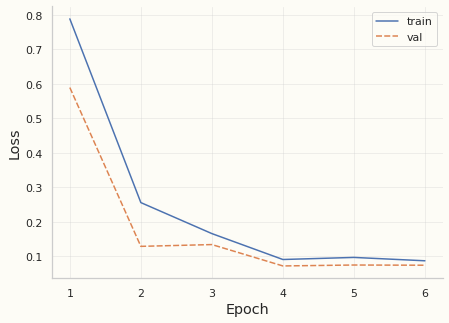

In [28]:
## Training
model, preprocessor, losses = train_model(model,
                                          preprocessor,
                                          dl_dict,
                                          criterion,
                                          optimizer,
                                          num_epochs)

## Plot Losses
plot_losses(losses)

device: cpu
-------Start Training-------


100%|██████████| 25/25 [00:13<00:00,  1.84it/s]


Epoch 1/6 | train |  Loss: 0.5703


100%|██████████| 25/25 [00:13<00:00,  1.83it/s]


Epoch 2/6 | train |  Loss: 0.1342


100%|██████████| 25/25 [00:13<00:00,  1.82it/s]


Epoch 3/6 | train |  Loss: 0.0840


100%|██████████| 25/25 [00:13<00:00,  1.88it/s]


Epoch 4/6 | train |  Loss: 0.0806


100%|██████████| 25/25 [00:13<00:00,  1.84it/s]


Epoch 5/6 | train |  Loss: 0.0737


100%|██████████| 25/25 [00:13<00:00,  1.89it/s]


Epoch 6/6 | train |  Loss: 0.0696


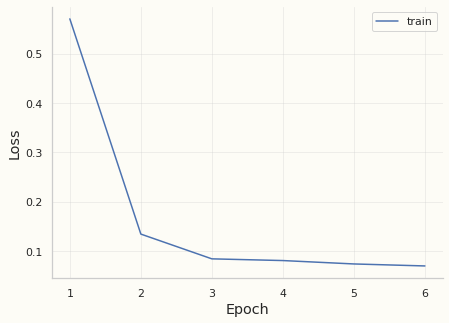

In [29]:
## Finalizing
if exp_config['finalize']:
    
    ## Making Dataset and DataLoader for Finalizing
    train_all_ds = TPSSep22TrainDataset(train_data, 
                                        numerical_columns,
                                        categorical_columns,
                                        history_period,
                                        horizon_period,
                                        n_items,
                                        target)
    
    train_all_dl = torch.utils.data.DataLoader(train_all_ds,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               drop_last=True)
    
    finalize_dl_dict = {'train': train_all_dl}
    
    ## Building Models
    preprocessor = Preprocessor(numerical_features,
                                categorical_features,
                                encoder_categories,
                                emb_dim)
    
    model = NBeatsModel(n_blocks,
                        n_stacks,
                        input_dim,
                        output_dim,
                        width)
    
    ## Loss Function
    criterion = nn.MSELoss()
    
    ## Optimizer and Learning Rate Scheduler
    learning_rate = exp_config['learning_rate']
    gamma = exp_config['gamma']
    params = list(preprocessor.parameters()) + list(model.parameters())
    optimizer = torch.optim.Adam(params=params,
                             lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    ## Model Training
    model, preprocessor, losses = train_model(model,
                                              preprocessor,
                                              finalize_dl_dict,
                                              criterion,
                                              optimizer,
                                              num_epochs,
                                              finalize=True)
    
    ## Plot losses
    plot_losses(losses, valid=False)

<a id ="6"></a><h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>6. Prediction</center></h1>

<a id ="6.1"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>6.1 Test Dataset</center></h2>
[Back to the TOC](#toc)

The number of test data is more than our model's forecasting period. Thus, we have to repeat forecasting with using predicted data as lookback histories. For this purpose, I added an "update" method to the dataset. This function recieves predicted data, and insert them into the DataFrame attribute.

In [30]:
## Dataset for Test Data
class TPSSep22TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_df, train_df,
                 numerical_columns, 
                 categorical_columns,
                 history_period=30,
                 horizon_period=30,
                 n_items=48):
        self.train_df = train_df
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.history_period = history_period
        self.horizon_period = horizon_period
        self.n_items = n_items
        self.before_start_idx = n_items * history_period
        self.after_end_idx = n_items * horizon_period
        
        last_train_data = self.train_df.iloc[-self.before_start_idx:]
        self.test_df = pd.concat([last_train_data, test_df], axis=0, ignore_index=True)
        
    def __len__(self):
        return (len(self.test_df) - self.before_start_idx) // self.after_end_idx + 1
    
    def __getitem__(self, index):
        data = {}
        index = (index * self.after_end_idx + self.before_start_idx)
        
        for i in range(self.n_items):
            item_index = index + i
            data[str(i)] = {}
            data[str(i)]['row_id'] = item_index
            
            past_data_ids = collect_past_data(item_index,
                                              self.history_period,
                                              self.n_items)
            x = torch.tensor(self.test_df['num_sold'][past_data_ids].values,
                             dtype=torch.float32)
            data[str(i)]['history'] = x

        return data
        
    def update(self, new_data, column, row_id):
        row_ids = collect_future_data(row_id,
                                      self.horizon_period,
                                      self.n_items)
        max_id = self.test_df.iloc[-1]['row_id']
        if row_ids[-1] <= max_id:
            self.test_df.loc[self.test_df['row_id'].isin(row_ids), column] = new_data
        else:
            row_ids = np.array(row_ids)
            max_len = (row_ids <= max_id).sum()
            row_ids = row_ids[:max_len]
            
            row_ids = row_ids.tolist()
            new_data = new_data[:max_len]
            self.test_df.loc[self.test_df['row_id'].isin(row_ids), column] = new_data

In [31]:
## Making Test Dataset
test_data = test_df.copy()
test_ds = TPSSep22TestDataset(test_data,
                              train_data,
                              numerical_columns,
                              categorical_columns,
                              history_period,
                              horizon_period,
                              n_items)

## Making Test DataLoader
test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size=1,
                                      shuffle=False,
                                      drop_last=False)

## Operation Check
print('length of test_ds: ', len(test_ds), '\n')
index = 0
test_sample = test_ds.__getitem__(index)
print('number of keys in test data: ', len(test_sample.keys()))
for key in test_sample.keys():
    print('row_id sample: ', test_sample[key]['row_id'])
    print('history sample shape: ', test_sample[key]['history'].shape)
    break

length of test_ds:  13 

number of keys in test data:  48
row_id sample:  2880
history sample shape:  torch.Size([60])


<a id ="6.2"></a><h2 style="background:#75E6DA; border:0; border-radius: 12px; color:black"><center>6.2 Test Data Prediction</center></h2>
[Back to the TOC](#toc)

In [32]:
## Function for the Test Data Prediction
def model_predict(model, preprocessor, test_dl):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')
    print('-------Start Prediction-------')
    model.to(device)
    
    preprocessor.eval()
    model.eval()
    
    for data_set in tqdm(test_dl):
        for i in range(n_items):
            data = data_set[str(i)]
            row_id = data['row_id'].item()
            row_id = row_id + test_dl.dataset.test_df['row_id'][0]
            x_nums = data['history']
            x_nums = x_nums.to(device)
            
            with torch.no_grad():
                outputs = model(x_nums)
                outputs = torch.squeeze(outputs)
                outputs = outputs.to('cpu').detach().numpy().copy()
                
            test_dl.dataset.update(outputs, 'num_sold', row_id)
            
    outputs = test_dl.dataset.test_df['num_sold']
    return outputs

In [33]:
## Prediction
outputs = model_predict(model, preprocessor, test_dl)
preds_normed = outputs.iloc[test_dl.dataset.before_start_idx:]

## post-processing
preds = (preds_normed * sc.scale_) + sc.mean_
submission_df['num_sold'] = preds.values
submission_df.to_csv('submission_cv.csv', index=False)

## Check
print('The number of null values: \n', submission_df.isnull().sum())
submission_df.head(10)

device: cpu
-------Start Prediction-------


100%|██████████| 13/13 [00:02<00:00,  6.43it/s]


The number of null values: 
 row_id      0
num_sold    0
dtype: int64


,row_id,num_sold
0,70128,390.749323
1,70129,361.134568
2,70130,284.471133
3,70131,448.592608
4,70132,127.876317
5,70133,122.705663
6,70134,101.642520
7,70135,150.435943
8,70136,389.989595
9,70137,356.272705


---
The evaluation score of N-BEATS is not as good as top-scored solutions in shared notebooks. This may be because N-BEATS is an univariate model. Making full use of all features' information would be a key to improving the quality of prediction. In addition, there's room for further consideration of hyperparameters of the model.

---

**Work in Progress...**

I'm going to update this notebook in soon. Please come again and checkout the progress. Thank you for reading!
